Makes sense to do a ratio test, as we're more invested in "test is no worse than 5% lower than control", rather than a fixed "test is no more than 2% points lower than control" (as some CVRs can be higher or lower).

Approach taken from NCSS' guide [Two Proportions – Non-Inferiority, Superiority, Equivalence, and Two-Sided Tests vs. a Margin](https://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Two_Proportions-Non-Inferiority,_Superiority,_Equivalence,_and_Two-Sided_Tests_vs_a_Margin.pdf), as with previous statistical approaches (i.e. as their guides include detailed formulae).

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.DataFrame.from_dict({'test': [60], 'ctrl': [60]},
                            orient='index',
                            columns=['don'])
df['total'] = 1000
df['non'] = df['total'] - df['don']
df

,don,total,non
test,60,1000,940
ctrl,60,1000,940


In [57]:
def mnratio(datafr, nim):
    """Miettinen-Nurminen Large-Sample Score Test of the Ratio
    
    Parameters
    ----------
    datafr : pd.DataFrame
        The data to run the test on.
        Columns: don, total
        Index: test, ctrl
        N.B. the convention here is that the experiment is indexed as 1, and the control as 2, in reverse of normal.
    nim : float, <1 when lower is worse.
        The Non-Inferiority Margin: the relative amount that P1 can be less than P2 and you still conclude that
        group 1 (treatment) is not inferior to group 2 (control). i.e. nim=0.95 => you'd accept a test that's 5%
        less than control but no lower.

    Returns
    -------
    z_MNR : float
        The z-score for the test.
    p_test : float
        The p-score for the test.
    """
    # From the dataframe
    N = datafr['total'].sum()
    M1 = datafr['don'].sum()
    n1 = datafr.loc['test', 'total']
    n2 = datafr.loc['ctrl', 'total']
    p1 = datafr.loc['test', 'don'] / n1
    p2 = datafr.loc['ctrl', 'don'] / n2
    # Interstitial values
    A = N * nim
    B = -(n1*nim + datafr.loc['test', 'don'] + n2 + datafr.loc['ctrl', 'don']*nim)
    C = M1
    # Constrain the p-values, to force p1t/p2t=nim
    p2t = (-B - np.sqrt(B**2 - 4*A*C)) / (2*A)
    p1t = p2t * nim
    # z-score
    z_MNR_num = (p1/p2 - nim)  # use regular p
    z_MNR_den = np.sqrt(((p1t*(1-p1t)/n1)+(nim**2)*(p2t*(1-p2t)/n2))*(N/(N-1)))  # use constrained p
    z_MNR = z_MNR_num / z_MNR_den
    # p-value
    p_test = norm.sf(z_MNR)

    return z_MNR, p_test

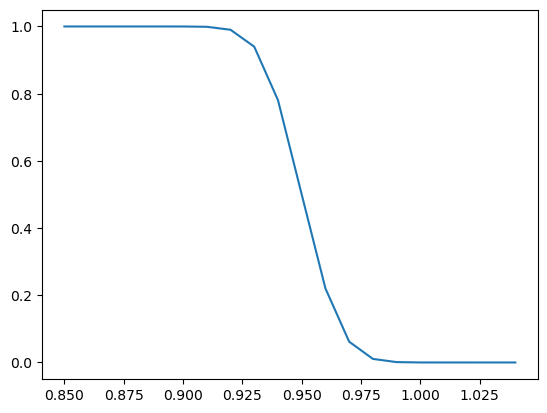

In [62]:
nim = 0.95
rates = []
p_scores = []
for t in np.arange(85, 105):
    df = pd.DataFrame.from_dict({'test': [t], 'ctrl': [100]},
                                orient='index',
                                columns=['don'])
    df['total'] = 1000
    df['non'] = df['total'] - df['don']
    df['rate'] = df['don'] / df['total']
    rates.append(df.loc['test', 'rate'] / df.loc['ctrl', 'rate'])
    p_scores.append(mnratio(df, nim)[1])    

plt.plot(rates, p_scores)

Works exactly as you'd expect: a full non-rejection for values substantially below the 95% threshold, still not happy about values at the threshold, and an easy reject at test values equal or greater than control.

In [63]:
nim = 0.95
cro84 = pd.DataFrame.from_dict({'test': [391, 2058], 'ctrl': [1444, 8254]},
                               orient='index',
                               columns=['don', 'total'])
noninf_z, noninf_p = mnratio(cro84, nim)

for_report = f"The test statistic is z(∆={nim}, N={cro84['total'].sum():,})={noninf_z:.2f}, p={noninf_p:.2f}"
if noninf_p < 0.05:
    for_report += "<0.05."
else:
    for_report += ">0.05."

print(for_report)

The test statistic is z(∆=0.95, N=10,312)=14.76, p=0.00<0.05.
